# Importing the Dataset

In [1]:
# loading libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline 

import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
df= pd.read_pickle("/kaggle/input/wm811k-wafer-map/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


# Data Preperation

In [3]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [4]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [5]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [6]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

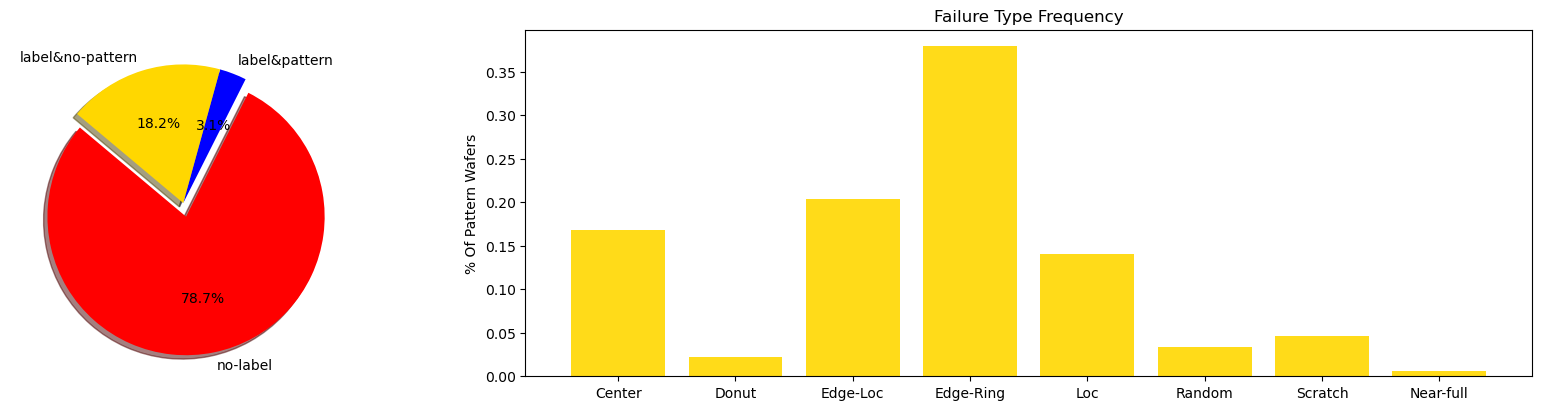

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['red', 'blue', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&no-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("Failure Type Frequency")
ax2.set_ylabel("% Of Pattern Wafers")
ax2.set_xticklabels(labels2)

plt.show()

# Denoising N1FAST for removing noise

In [8]:
df = df_withlabel.copy()

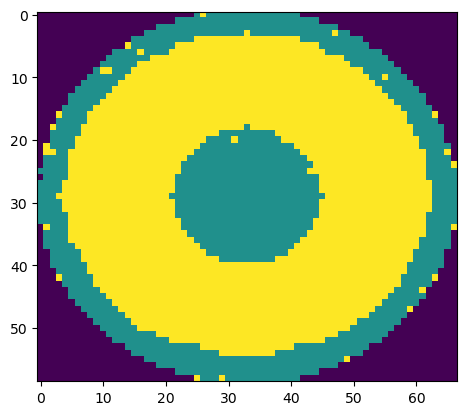

In [9]:
plt.imshow(df['waferMap'][9676])

In [10]:
import cv2

# Apply mean filtering with a 3x3 window and a mean threshold of 1.25 
# Denoisng the image so as to cause less confusion to the model 
for i in range(len(df)): 
   df['waferMap'][i]=  cv2.fastNlMeansDenoising(df['waferMap'][i], None, 0.75, 3, 3)

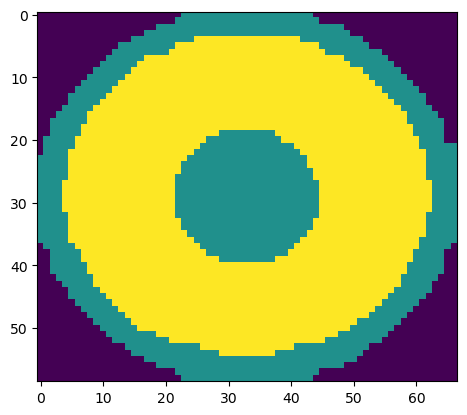

In [11]:
plt.imshow( df['waferMap'][9676])

# AE Data Augmentation 

In [12]:
import os
from os.path import join

import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [13]:
#df = df_withlabel.copy()

In [14]:
df = df.copy() # original with denoisng

In [15]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,index,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,failureNum,trainTestNum,waferMapDim
23377,375726,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7870.0,lot22418,18.0,[[Training]],[[Edge-Loc]],2,0,"(63, 160)"
169107,807449,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...",1060.0,lot47377,19.0,[[Test]],[[none]],8,1,"(41, 33)"
73299,705036,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1,...",516.0,lot43226,18.0,[[Training]],[[none]],8,0,"(25, 27)"
105854,739837,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1507.0,lot44635,16.0,[[Test]],[[none]],8,1,"(43, 44)"
24990,436911,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",1080.0,lot26424,1.0,[[Training]],[[Edge-Loc]],2,0,"(35, 40)"


In [16]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [17]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [18]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


In [19]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [20]:
x = x.reshape((-1, 26, 26, 1))

In [21]:
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [22]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same')(input_tensor)
encode = layers.BatchNormalization()(encode)
encode = layers.Activation('relu')(encode)

encode = layers.Conv2D(128, (3,3), padding='same')(encode)
encode = layers.BatchNormalization()(encode)
encode = layers.Activation('relu')(encode)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(128, (3,3), padding='same')
decode_layer_2 = layers.BatchNormalization()
decode_layer_3 = layers.Activation('relu')
decode_layer_4 = layers.UpSampling2D()

decode_layer_5 = layers.Conv2DTranspose(64, (3,3), padding='same')
decode_layer_6 = layers.BatchNormalization()
decode_layer_7 = layers.Activation('relu')

output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='linear')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)
decode = decode_layer_3(decode)
decode = decode_layer_4(decode)

decode = decode_layer_5(decode)
decode = decode_layer_6(decode)
decode = decode_layer_7(decode)

output = output_tensor(decode)

ae = models.Model(input_tensor, output)
ae.compile(optimizer='Adam', loss='mse')

epoch=30
batch_size=512
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

encoder = models.Model(input_tensor, latent_vector)
decoder_input = Input((13, 13, 128))  # change the input shape here
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)
decode = decode_layer_3(decode)
decode = decode_layer_4(decode)

decode = decode_layer_5(decode)
decode = decode_layer_6(decode)
decode = decode_layer_7(decode)

output = output_tensor(decode)

decoder = models.Model(decoder_input, output)
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 128))  # change the shape of the noise
# check original faulty wafer data



Epoch 1/30
29/29 - 195s - loss: 0.1812 - 195s/epoch - 7s/step
Epoch 2/30
29/29 - 190s - loss: 0.0176 - 190s/epoch - 7s/step
Epoch 3/30
29/29 - 188s - loss: 0.0125 - 188s/epoch - 6s/step
Epoch 4/30
29/29 - 179s - loss: 0.0106 - 179s/epoch - 6s/step
Epoch 5/30
29/29 - 180s - loss: 0.0094 - 180s/epoch - 6s/step
Epoch 6/30
29/29 - 179s - loss: 0.0085 - 179s/epoch - 6s/step
Epoch 7/30
29/29 - 180s - loss: 0.0077 - 180s/epoch - 6s/step
Epoch 8/30
29/29 - 178s - loss: 0.0071 - 178s/epoch - 6s/step
Epoch 9/30
29/29 - 177s - loss: 0.0066 - 177s/epoch - 6s/step
Epoch 10/30
29/29 - 178s - loss: 0.0061 - 178s/epoch - 6s/step
Epoch 11/30
29/29 - 181s - loss: 0.0057 - 181s/epoch - 6s/step
Epoch 12/30
29/29 - 179s - loss: 0.0053 - 179s/epoch - 6s/step
Epoch 13/30
29/29 - 178s - loss: 0.0050 - 178s/epoch - 6s/step
Epoch 14/30
29/29 - 181s - loss: 0.0047 - 181s/epoch - 6s/step
Epoch 15/30
29/29 - 183s - loss: 0.0044 - 183s/epoch - 6s/step
Epoch 16/30
29/29 - 184s - loss: 0.0042 - 184s/epoch - 6s/step
E

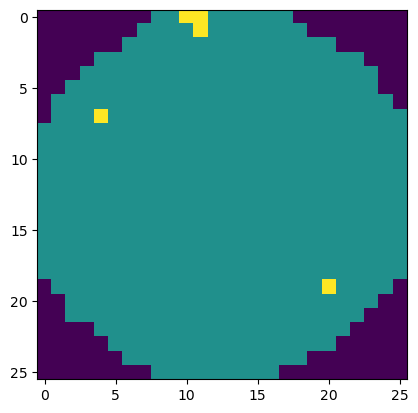

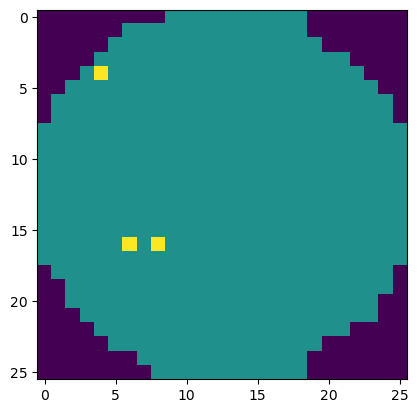

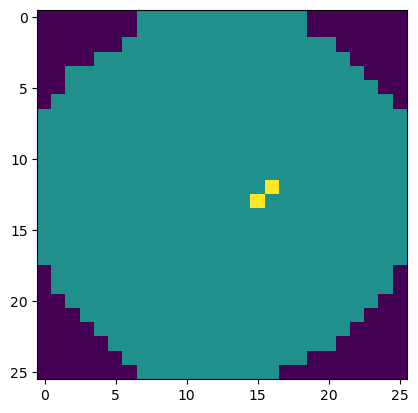

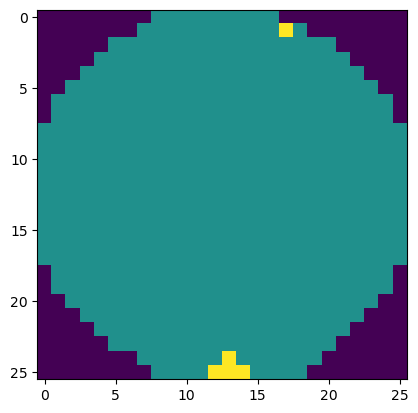

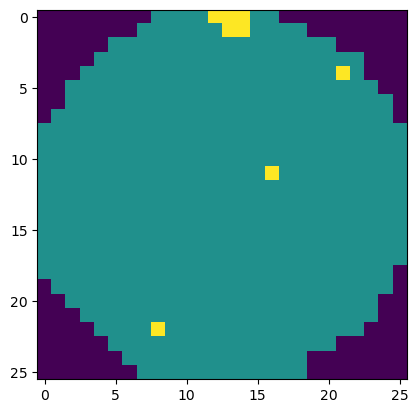

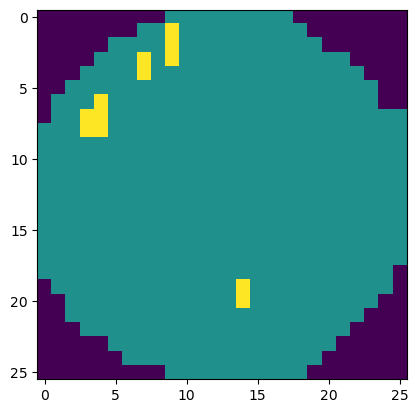

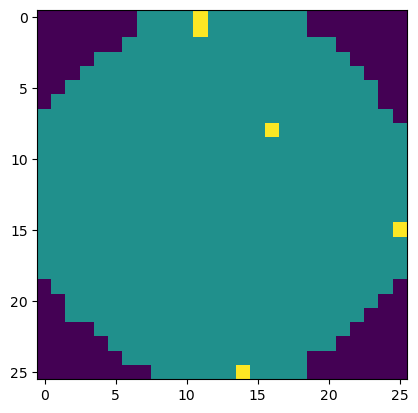

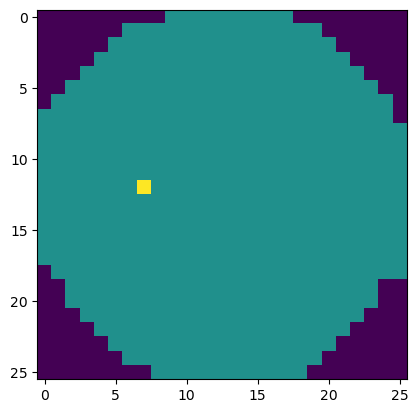

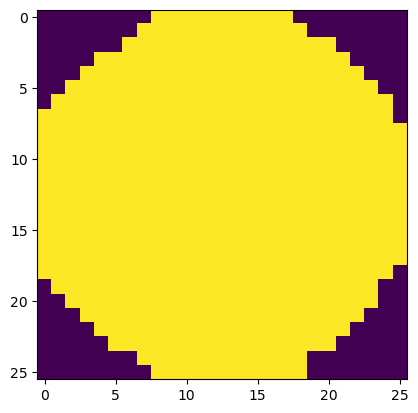

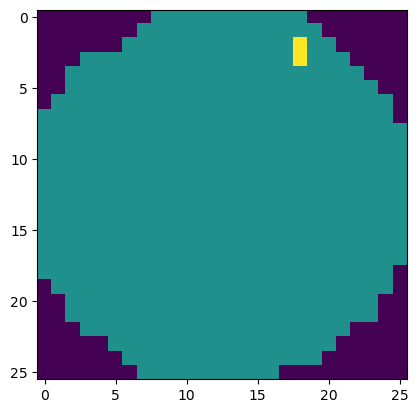

In [23]:
for i in range(10):
    plt.imshow(np.argmax(new_x[i], axis=2))
    
    plt.show()

449/449 [==============================] - 45s 99ms/step


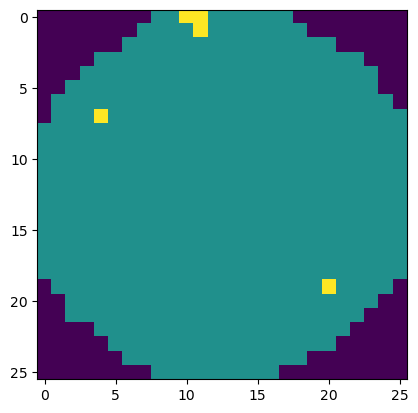

449/449 [==============================] - 45s 101ms/step


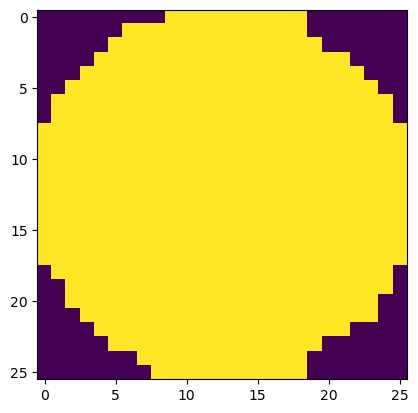

449/449 [==============================] - 47s 105ms/step


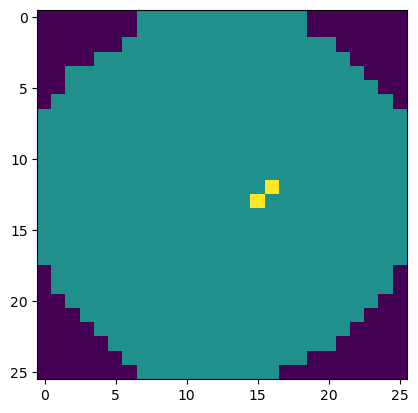

449/449 [==============================] - 47s 104ms/step


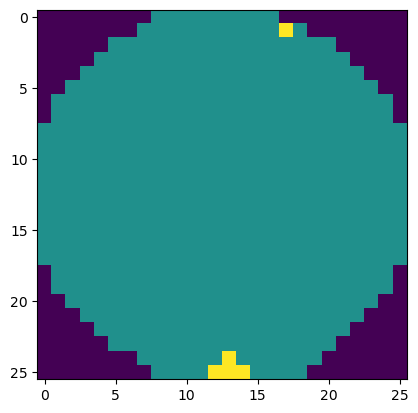

449/449 [==============================] - 45s 100ms/step


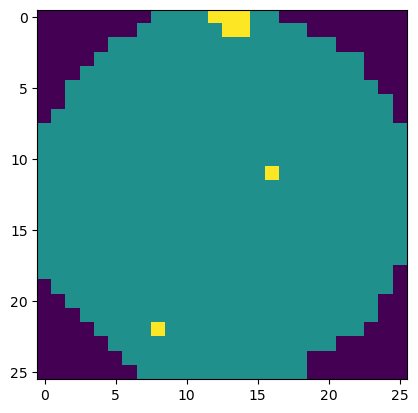

449/449 [==============================] - 45s 100ms/step


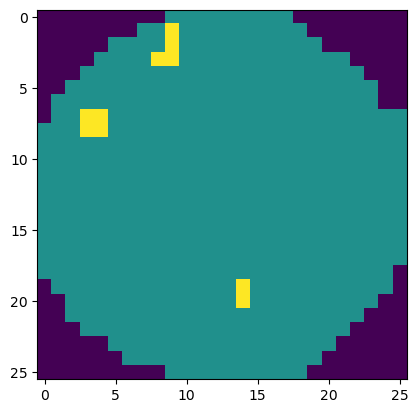

449/449 [==============================] - 44s 99ms/step


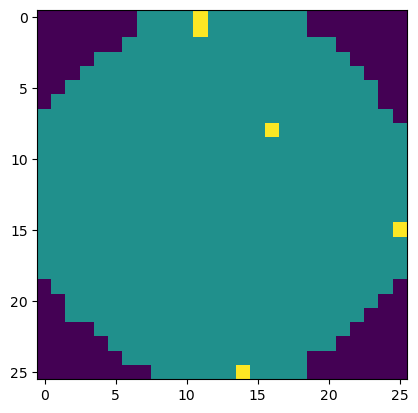

449/449 [==============================] - 47s 106ms/step


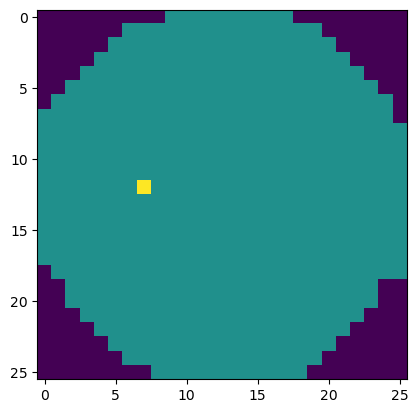

449/449 [==============================] - 46s 102ms/step


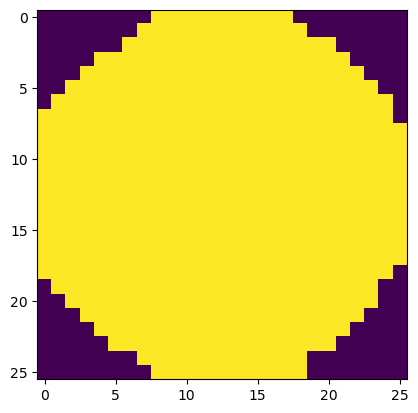

449/449 [==============================] - 50s 111ms/step


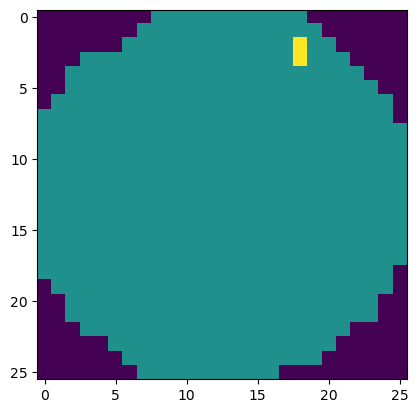

In [24]:
# check new noised faulty wafer data
for i in range(10):
    noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
    plt.imshow(noised_gen_x[i])
    plt.show()

In [25]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # Get number of filters in encoder
    num_filters = encoded_x.shape[-1]
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, num_filters)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return data without 1st dummy data.
    return gen_x[1:], gen_y[1:]


In [26]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))


3/3 [==============================] - 0s 62ms/step


In [27]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

After Generate new_x shape : (30707, 26, 26, 3), new_y shape : (30707, 1)
Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [28]:
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

After Delete "none" class new_x shape : (19707, 26, 26, 3), new_y shape : (19707, 1)
Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 2489


# UMAP EDA

In [29]:
new_x.shape

(19707, 26, 26, 3)

In [30]:
new_y.shape

(19707, 1)

In [31]:
labels

['no-label', 'label&pattern', 'label&no-pattern']

In [32]:
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

In [33]:
import numpy as np

# Flatten the last three dimensions of the new_x array
reshaped_data = np.reshape(new_x, (19707, -1))

# Check the shape of the reshaped array
print(reshaped_data.shape)  

(19707, 2028)


In [34]:
import numpy as np
import sklearn.datasets
import sklearn.neighbors


import numpy as np
import sklearn.datasets
import sklearn.neighbors
import umap.umap_ as umap
import umap.plot
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
mapper = umap.UMAP(n_neighbors=5, min_dist=0.8).fit(reshaped_data)

In [36]:
import numpy as np

# Example label array of shape (100, 9)

# Convert to 1D array of shape (100)
ya = np.argmax(new_y, axis=1)
print(ya.shape) 


(19707,)


<AxesSubplot:>

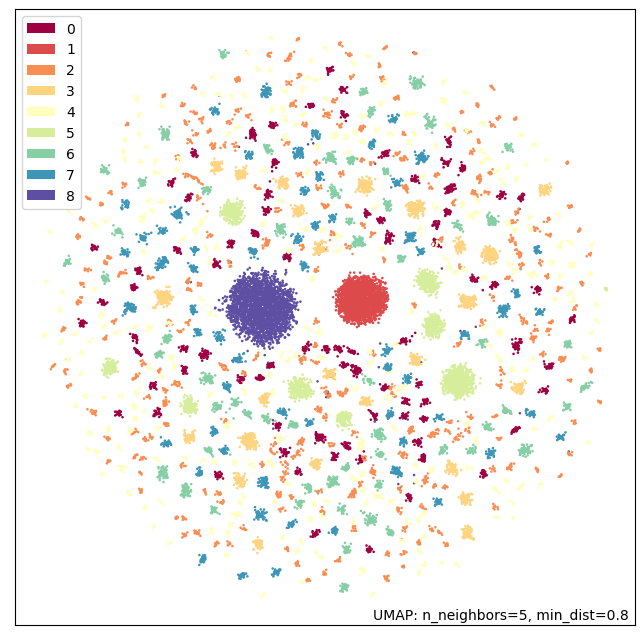

In [37]:
umap.plot.points(mapper,labels=ya)

In [38]:
new_x.shape

(19707, 26, 26, 3)

In [39]:
# concatentate the frAmes

ya.shape

(19707,)

In [40]:
len(ya)

19707

# 

# Converting the wafer maps to images 

In [41]:
!mkdir -p 0 1 2 3 4 5 6 7 8

In [ ]:
import os

batch_size = 50

for j in range(len(ya)):
    img = new_x[j]
    # Loop over each image in the current failure type
    for i in range(len(img)):
        # Create a new figure for each image
        fig, ax = plt.subplots()
        ax.imshow(img)
        ax.set_axis_off()
        plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
        plt.margins(0,0)
        
        # Create directory if it doesn't exist
        if not os.path.exists(str(ya[j])):
            os.makedirs(str(ya[j]))

        plt.savefig(str(ya[j]) + "/image_" + str(i) + ".png", bbox_inches='tight',dpi=100)
        plt.close()

        # Clear memory every batch_size images
        if (i + 1) % batch_size == 0:
            plt.close('all')
            plt.cla()
            plt.clf()
            del img
            del fig
            del ax
            img = None
            fig = None
            ax = None

    # Clear memory after each batch is complete
    plt.close('all')
    plt.cla()
    plt.clf()
    del img
    del fig
    del ax
    img = None
    fig = None
    ax = None

print('done')


In [ ]:
# code to download the directory on local
import os
os.chdir(r'/kaggle/working')

!tar -czf All.tar.gz /kaggle/working/

from IPython.display import FileLink

FileLink(r'All.tar.gz')

# 13 Regions Density Based Feature Extraction

In [ ]:
def cal_den(x):
    return 100*(np.sum(x==2)/np.size(x))  # MARKED UNDONE DF NOT CHANGE TO APPROPRIATE ONE 2. DO A CHECK ON THE "NONE" CLASS TO SEE IF ITS INCLUDED

def find_regions(x):
    rows=np.size(x,axis=0)
    cols=np.size(x,axis=1)
    ind1=np.arange(0,rows,rows//5)
    ind2=np.arange(0,cols,cols//5)
    
    reg1=x[ind1[0]:ind1[1],:]
    reg3=x[ind1[4]:,:]
    reg4=x[:,ind2[0]:ind2[1]]
    reg2=x[:,ind2[4]:]

    reg5=x[ind1[1]:ind1[2],ind2[1]:ind2[2]]
    reg6=x[ind1[1]:ind1[2],ind2[2]:ind2[3]]
    reg7=x[ind1[1]:ind1[2],ind2[3]:ind2[4]]
    reg8=x[ind1[2]:ind1[3],ind2[1]:ind2[2]]
    reg9=x[ind1[2]:ind1[3],ind2[2]:ind2[3]]
    reg10=x[ind1[2]:ind1[3],ind2[3]:ind2[4]]
    reg11=x[ind1[3]:ind1[4],ind2[1]:ind2[2]]
    reg12=x[ind1[3]:ind1[4],ind2[2]:ind2[3]]
    reg13=x[ind1[3]:ind1[4],ind2[3]:ind2[4]]
    
    fea_reg_den = []
    fea_reg_den = [cal_den(reg1),cal_den(reg2),cal_den(reg3),cal_den(reg4),cal_den(reg5),cal_den(reg6),cal_den(reg7),cal_den(reg8),cal_den(reg9),cal_den(reg10),cal_den(reg11),cal_den(reg12),cal_den(reg13)]
    return fea_reg_den

df['fea_reg']=df.waferMap.apply(find_regions)

In [ ]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,13,13),df_withpattern.fea_reg[x[i]])
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show() 

# Geometric Feature Extraction 

In [ ]:
def cal_dist(img,x,y):
    dim0=np.size(img,axis=0)    
    dim1=np.size(img,axis=1)
    dist = np.sqrt((x-dim0/2)**2+(y-dim1/2)**2)
    return dist  

def fea_geom(img):
    norm_area=img.shape[0]*img.shape[1]
    norm_perimeter=np.sqrt((img.shape[0])**2+(img.shape[1])**2)
    
    img_labels = measure.label(img, neighbors=4, connectivity=1, background=0)

    if img_labels.max()==0:
        img_labels[img_labels==0]=1
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>0], axis = None)
        no_region = info_region[0][0]-1       
    
    prop = measure.regionprops(img_labels)
    prop_area = prop[no_region].area/norm_area
    prop_perimeter = prop[no_region].perimeter/norm_perimeter 
    
    prop_cent = prop[no_region].local_centroid 
    prop_cent = cal_dist(img,prop_cent[0],prop_cent[1])
    
    prop_majaxis = prop[no_region].major_axis_length/norm_perimeter 
    prop_minaxis = prop[no_region].minor_axis_length/norm_perimeter  
    prop_ecc = prop[no_region].eccentricity  
    prop_solidity = prop[no_region].solidity  
    
    return prop_area,prop_perimeter,prop_majaxis,prop_minaxis,prop_ecc,prop_solidity

df_withpattern_copy['fea_geom'] =df_withpattern_copy.waferMap.apply(fea_geom)

In [ ]:
df_all=df_withpattern_copy.copy()
a=[df_all.fea_reg[i] for i in range(df_all.shape[0])] #13
d=[df_all.fea_geom[i] for i in range(df_all.shape[0])] #6
fea_all = np.concatenate((np.array(a),np.array(b),np.array(c),np.array(d)),axis=1) #59 in total

In [ ]:
label=[df_all.failureNum[i] for i in range(df_all.shape[0])]
label=np.array(label)

# GLCM BASED FEATURE EXTRACTION

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import requests
import os
import random
import pickle
import tensorflow as jf
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
import pathlib

from tensorflow.keras.callbacks import EarlyStopping
from skimage.filters import gabor
from skimage.filters import gabor_kernel

import glob
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, concatenate,Conv2D,MaxPooling2D, Flatten,Dense,BatchNormalization

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import NASNetLarge
import cv2

In [ ]:
# Remove all white borders 


In [ ]:
import os

SIZE = 256
BATCH_SIZE = 15
TARGET_SIZE = (SIZE,SIZE)
# Set the directory path where your images are stored
dir_path = '/kaggle/input/v5minor100/V5Minor100'


images = []
labels = []
ough the directory and load each image
for folder in os.listdir(dir_path):
    print(folder)
    for img in os.listdir(os.path.join(dir_path, folder)):
        try: 
            img = "/kaggle/input/v5minor100/V5Minor100/" + folder + "/" + img

            image = cv2.imread(img, 3)
            image = cv2.resize(image, TARGET_SIZE)
            # Append the image to the images list
            image = np.array(image)
            images.append(image)
            # Append the label to the labels list
            labels.append(folder)

        except:
            pass
        
        

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
print(len(X_train))
print(len(X_val))
print(len(X_test))

In [ ]:
import skimage
from scipy import ndimage
import numpy as np
from skimage.measure import shannon_entropy
from scipy.stats import entropy
from skimage import io, color, feature, measure


def feature_extractor(images):
    image_dataset = pd.DataFrame()
    for img in images:   
        dists = [1]
        angles = [0]
        
        
        df = pd.DataFrame()
        # Extract GLCM features for R channel
        glcm_r = skimage.feature.graycomatrix(img[:, :, 0], dists, angles, 256, symmetric=True, normed=True)
        # Extract GLCM features for G channel
        glcm_g = skimage.feature.graycomatrix(img[:, :, 1],dists,  angles, 256, symmetric=True, normed=True)
        # Extract GLCM features for B channel
        glcm_b = skimage.feature.graycomatrix(img[:, :, 2], dists,  angles, 256, symmetric=True, normed=True)
        # Extract GLCM features for RG channel
        img_rg = np.zeros((img.shape[0], img.shape[1], 2))
        img_rg[:, :, 0] = img[:, :, 0]
        img_rg[:, :, 1] = img[:, :, 1]
        img_rg_8bit = img_rg[:,:,1].astype(np.uint8)
        glcm_rg = skimage.feature.graycomatrix(img_rg_8bit, dists,  angles, 256, symmetric=True, normed=True)
        # Extract GLCM features for RB channel
        img_rb = np.zeros((img.shape[0], img.shape[1], 2))
        img_rb[:, :, 0] = img[:, :, 0]
        img_rb[:, :, 1] = img[:, :, 2]
        img_rb_8bit = img_rb[:,:,1].astype(np.uint8)
        glcm_rb = skimage.feature.graycomatrix(img_rb_8bit, dists,  angles, 256, symmetric=True, normed=True)
        # Extract GLCM features for GB channel
        img_gb = np.zeros((img.shape[0], img.shape[1], 2))
        img_gb[:, :, 0] = img[:, :, 1]
        img_gb[:, :, 1] = img[:, :, 2]
        img_gb_8bit = img_gb[:,:,1].astype(np.uint8)
        glcm_gb = skimage.feature.graycomatrix(img_gb_8bit, dists,  angles, 256, symmetric=True, normed=True)
             

        # Extract the contrast, correlation, energy, and homogeneity properties
        for i, glcm in enumerate([glcm_r, glcm_g, glcm_b, glcm_rg, glcm_rb, glcm_gb]):
            df[f'contrast_{i}'] = skimage.feature.graycoprops(glcm, 'contrast')[0]
            df[f'correlation_{i}'] = skimage.feature.graycoprops(glcm, 'correlation')[0]
            df[f'energy_{i}'] = skimage.feature.graycoprops(glcm, 'energy')[0]
            df[f'homogeneity_{i}'] = skimage.feature.graycoprops(glcm, 'homogeneity')[0]
            df[f'dissimilarity_{i}'] = skimage.feature.graycoprops(glcm, 'dissimilarity')[0]
            df['Entropy_glcm_r'] = shannon_entropy(img[:, :, 0])
            df['Entropy_glcm_g'] = shannon_entropy(img[:, :, 1])
            df['Entropy_glcm_b'] = shannon_entropy(img[:, :, 2])
            df['Entropy_glcm_rg'] = shannon_entropy(img_rg_8bit)
            df['Entropy_glcm_gb'] = shannon_entropy(img_gb_8bit)           
            df['Entropy_glcm_rb'] = shannon_entropy(img_rb_8bit)
            #df['Entropy_glcm_rgb'] = shannon_entropy(img)


        image_dataset = image_dataset.append(df, ignore_index=True)

    return image_dataset

In [ ]:
train_extr_features = feature_extractor(X_train)
test_extr_features = feature_extractor(X_test)
val_extr_features = feature_extractor(X_val)

In [ ]:
# Convert the input data to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

In [ ]:
train_images_norm = X_train.astype('float32')
test_images_norm = X_test.astype('float32')
val_images_norm = X_val.astype('float32')
# normalize to the range 0-1
train_images_norm /= 255.0
test_images_norm /= 255.0
val_images_norm /= 255.0

# RESNET 50 + AUTOENCODER + MLP + ADABOOST USING FEATURE EXTRACTION  

In [ ]:
def deep_build_mlp():
    model = keras.Sequential([
    Dense(128, input_shape=(62,), activation='relu'),
    Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    Dense(32, activation='relu'),
    keras.layers.BatchNormalization(),
    Dense(16, activation='relu'),
    keras.layers.BatchNormalization(),
    Dense(8, activation='relu'),
    keras.layers.BatchNormalization()   
    ])
    print(model.summary())
    return model

def build_cnn():

    model = Sequential()

    pretrained_model=tf.keras.applications.resnet.ResNet50(include_top=False,
                      input_shape=(256,256,3),
                      pooling='avg',classes=2,
                      weights='imagenet')
    for layer in pretrained_model.layers:
             layer.trainable=True 

    model.add(pretrained_model)
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    return model

def build_cnn_BASE():
    model = keras.Sequential([
        keras.Input(shape=(256,256,3), name='Original_Images'),
        keras.layers.Conv2D(input_shape=(256,256,3), filters=32, kernel_size=11, 
                            strides=1, activation='relu', name='Conv1'),
        keras.layers.Conv2D(input_shape=(240,240,32), filters=32, kernel_size=11, 
                            strides=1, activation='relu', name='Conv2'),
        keras.layers.MaxPool2D(pool_size=(5, 5), strides=2),
        keras.layers.Conv2D(input_shape=(58,58,32), filters=64, kernel_size=9, 
                            strides=1, activation='relu', name='Conv3'),
        keras.layers.MaxPool2D(pool_size=(5, 5), strides=2),
        keras.layers.Conv2D(input_shape=(23,23,64), filters=128, kernel_size=8, 
                            strides=1, activation='relu', name='Conv4'),
        keras.layers.Conv2D(input_shape=(16,16,128), filters=256, kernel_size=9, 
                            strides=1, activation='relu', name='Conv5'),
        keras.layers.Conv2D(input_shape=(8,8,256), filters=256, kernel_size=8, 
                            strides=1, activation='relu', name='Conv6'),    

        keras.layers.Flatten(),
        keras.layers.Dense(8, activation=tf.keras.activations.relu, name='Dense')
    ])
    print(model.summary())
    return model


def build_autoencoder():
    model = keras.Sequential()
    input_layer = keras.Input(shape=(36,), name='Input')
    
    # Encoder
    encoded = keras.layers.Dense(128, activation='relu')(input_layer)
    encoded = keras.layers.BatchNormalization()(encoded)
    encoded = keras.layers.Dense(64, activation='relu')(encoded)
    encoded = keras.layers.Dropout(0.2)(encoded)
    encoded = keras.layers.Dense(32, activation='relu')(encoded)
    encoded = keras.layers.BatchNormalization()(encoded)
    
    # Decoder
    decoded = keras.layers.Dense(64, activation='relu')(encoded)
    decoded = keras.layers.BatchNormalization()(decoded)
    decoded = keras.layers.Dense(128, activation='relu')(decoded)
    decoded = keras.layers.Dropout(0.2)(decoded)
    decoded = keras.layers.Dense(37, activation='linear')(decoded)
    
    # Define the model
    model = keras.Model(inputs=input_layer, outputs=decoded)
    print(model.summary())
    return model


def build_mlp():
    model = keras.Sequential([
        keras.Input(shape=37, name='Extracted_Traditional_Features'),
        keras.layers.Dense(4, activation=tf.keras.activations.relu, name='Dense1'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(2, activation=tf.keras.activations.relu, name='Dense2'),
        keras.layers.BatchNormalization()
    ])
    print(model.summary())
    return model

In [ ]:
cnn = build_cnn()
DMLP = build_autoencoder()
combinedInput = concatenate([DMLP.output, cnn.output])

x = Dense(64, activation="relu")(combinedInput)
keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)
keras.layers.BatchNormalization()(x)
x = Dropout(0.27)(x)
x = Dense(16, activation="relu")(x)
keras.layers.BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(4, activation="relu")(x)
keras.layers.BatchNormalization()(x)
x = Dropout(0.05)(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[DMLP.input, cnn.input], outputs=x)

In [ ]:
opt = keras.optimizers.SGD()
model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

from tensorflow.keras.callbacks import ReduceLROnPlateau

cb = [
    ReduceLROnPlateau(
        monitor='val_binary_accuracy',
        factor=0.1,
        patience=3,
        mode='auto',
        min_delta=0.0002,
        cooldown=5,
        min_lr=10e-10,
        verbose=1,
    )
]
    


# dataset_label = tf.data.Dataset.from_tensor_slices(y_train)
from keras.callbacks import ModelCheckpoint

# Create a ModelCheckpoint callback to save the weights of the best model
checkpoint = ModelCheckpoint('/kaggle/working/best_model_weights.h5', monitor='val_binary_accuracy', save_best_only=True, save_weights_only=True, mode='max', verbose=1)


# fit model
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=10,restore_best_weights=True)

history = model.fit(x=[train_extr_features, train_images_norm],y=y_train,epochs = 100, steps_per_epoch=200,validation_data=([val_extr_features,val_images_norm],y_val),callbacks=[cb,early_stopping,checkpoint])

# EVALUATION & Analysis
The results were good > 70% but converting to images is to inefficient in the real world. The time for inference and everything takes more than a few seconds. This is not good. 

Note: change the handlign of data, reduce time inference, use the already given data, do not convert it to images.  Try GANS and ISOlation, rember to change multi - binary class classification
